<a href="https://colab.research.google.com/github/gregorio-saporito/Spark-AMD/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding similar items: StackSample
Gregorio Luigi Saporito - DSE (2020-2021)

### Upload to session storage the Kaggle API token

In [1]:
from google.colab import files
uploaded = files.upload()

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Saving kaggle.json to kaggle.json


### Download the dataset through the Kaggle API

In [2]:
# access permissions with the API token
!chmod 600 /content/kaggle.json
!kaggle datasets download -d stackoverflow/stacksample
!unzip \*.zip && rm *.zip
# remove datasets which are not needed
!rm Answers.csv
!rm Tags.csv

 99% 1.09G/1.11G [00:06<00:00, 208MB/s]
100% 1.11G/1.11G [00:06<00:00, 181MB/s]
Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


### Spark environment setup

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz 
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
!rm /content/spark-3.1.1-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

import findspark
findspark.init("spark-3.1.1-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

import pyspark
type(spark)

sc = spark.sparkContext

### Load Dataset
Spark reads files line by line for performance reasons and CSVs with newline characters cause problems for the parser. In this case the Body column of the file "Questions.csv" has characters like `"\n"` and `"\r"` which compromise the correct loading of the dataset. When the parser finds a newline character in a string it loads the remaining part in a new line incorrectly splitting the string and loading the remaning part of the string in a new line of the DataFrame which often corresponds to a wrong column (most of the remaining columns are then filled with null values). To solve this problem the escape character `"\""` is manually specified as an option when loading the .csv file with Spark, resulting in the correct loading of the dataset.

In [4]:
df = spark.read\
  .option("multiLine", "true")\
  .option("header", "true")\
  .option("escape", "\"")\
  .csv("Questions.csv")\
  .select("Id","Body")

df.show(10)

+---+--------------------+
| Id|                Body|
+---+--------------------+
| 80|<p>I've written a...|
| 90|<p>Are there any ...|
|120|<p>Has anyone got...|
|180|<p>This is someth...|
|260|<p>I have a littl...|
|330|<p>I am working o...|
|470|<p>I've been writ...|
|580|<p>I wonder how y...|
|650|<p>I would like t...|
|810|<p>I'm trying to ...|
+---+--------------------+
only showing top 10 rows



In [5]:
# how many observations
df.count()

1264216

### Dataset Cleaning

In [6]:
# check for missing values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+
| Id|Body|
+---+----+
|  0|   0|
+---+----+



In [7]:
from pyspark.sql.functions import col, lower, regexp_replace, split

def clean_html(x):
  x = regexp_replace(x, '<.*?>', '')
  x = regexp_replace(x, '\n|\r', '')
  return x

df = df.select("Id", clean_html(col("Body")).alias("Body"))

In [8]:
df.show(10)

+---+--------------------+
| Id|                Body|
+---+--------------------+
| 80|I've written a da...|
| 90|Are there any rea...|
|120|Has anyone got ex...|
|180|This is something...|
|260|I have a little g...|
|330|I am working on a...|
|470|I've been writing...|
|580|I wonder how you ...|
|650|I would like the ...|
|810|I'm trying to mai...|
+---+--------------------+
only showing top 10 rows



In [9]:
# extracting tokens from text
from pyspark.ml.feature import RegexTokenizer

regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'Body', outputCol = 'tokens')
tokenised = regexTokenizer.transform(df)
tokenised.show(3)

+---+--------------------+--------------------+
| Id|                Body|              tokens|
+---+--------------------+--------------------+
| 80|I've written a da...|[i, ve, written, ...|
| 90|Are there any rea...|[are, there, any,...|
|120|Has anyone got ex...|[has, anyone, got...|
+---+--------------------+--------------------+
only showing top 3 rows



In [10]:
# stopwords removal
from pyspark.ml.feature import StopWordsRemover
swr = StopWordsRemover(inputCol = 'tokens', outputCol = 'sw_removed')
Body_swr = swr.transform(tokenised)
Body_swr.show(3)

+---+--------------------+--------------------+--------------------+
| Id|                Body|              tokens|          sw_removed|
+---+--------------------+--------------------+--------------------+
| 80|I've written a da...|[i, ve, written, ...|[ve, written, dat...|
| 90|Are there any rea...|[are, there, any,...|[really, good, tu...|
|120|Has anyone got ex...|[has, anyone, got...|[anyone, got, exp...|
+---+--------------------+--------------------+--------------------+
only showing top 3 rows



### Jaccard Distance Approach with LSH

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, MinHashLSH
import pyspark.sql.functions as f
from pyspark.sql.functions import monotonically_increasing_id 

jd_df = Body_swr\
  .withColumn("nodup", f.array_distinct("sw_removed"))\
  .select("Id","nodup")

In [13]:
jd_df.show(3)

+---+--------------------+
| Id|               nodup|
+---+--------------------+
| 80|[ve, written, dat...|
| 90|[really, good, tu...|
|120|[anyone, got, exp...|
+---+--------------------+
only showing top 3 rows



In [12]:
jd_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- nodup: array (nullable = true)
 |    |-- element: string (containsNull = true)



Empty arrays are removed. For simplicity and faster reproducibility of the results, the algorithm is run on a smaller portion of the dataset (20,000 observations)

In [24]:
from pyspark.sql.functions import col, size
# filter out empty arrays of strings and use a smaller chunk of the dataset
jd_df_clean = jd_df.where((size(col("nodup")) >= 1)).limit(20000)

In [25]:
import time
# track time
start = time.time()

model = Pipeline(stages=[
        HashingTF(inputCol="nodup", outputCol="vectors"),
        MinHashLSH(inputCol="vectors", outputCol="lsh", seed=123)
    ]).fit(jd_df_clean)

db_hashed = model.transform(jd_df_clean)

print("Approximately joining on distance smaller than 0.5:")
db_matches = model.stages[-1].approxSimilarityJoin(db_hashed, db_hashed, 0.5)

#show all matches (including duplicates)
db_matches.select(f.col('datasetA.Id').alias('id_A'),
                 f.col('datasetB.Id').alias('id_B'),
                 f.col('distCol')).show()

end = time.time()
print(round(end-start,2))

Approximately joining on distance smaller than 0.5:
+----+----+-------+
|id_A|id_B|distCol|
+----+----+-------+
|  80|  80|    0.0|
|  90|  90|    0.0|
| 120| 120|    0.0|
| 180| 180|    0.0|
| 260| 260|    0.0|
| 330| 330|    0.0|
| 470| 470|    0.0|
| 580| 580|    0.0|
| 650| 650|    0.0|
| 810| 810|    0.0|
| 930| 930|    0.0|
|1010|1010|    0.0|
|1040|1040|    0.0|
|1070|1070|    0.0|
|1160|1160|    0.0|
|1180|1180|    0.0|
|1300|1300|    0.0|
|1390|1390|    0.0|
|1600|1600|    0.0|
|1610|1610|    0.0|
+----+----+-------+
only showing top 20 rows

75.94


In [26]:
#show non-duplicate matches
db_matches.select(f.col('datasetA.id').alias('id_A'),
                 f.col('datasetB.id').alias('id_B'),
                 f.col('distCol')).filter('id_A < id_B').show()

+-------+-------+-------------------+
|   id_A|   id_B|            distCol|
+-------+-------+-------------------+
| 446500| 446600|0.48888888888888893|
| 503310| 835280|              0.375|
| 612820| 634630|0.49056603773584906|
|1041520|1042370|0.30434782608695654|
+-------+-------+-------------------+



In [17]:
# example 1
df.where((col("id") == 612820) | (col("id") == 634630)).show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
# example 2
df.where((col("id") == 1041520) | (col("id") == 1042370)).show(truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id     |Body                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------

### Some performance considerations
A series of tests on the computational performance of Spark in Google Colab were performed to track the computational time required to run the LSH algorithm as a function of the dataset size.

In [19]:
import pandas as pd
d = {'size': [100, 200, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
     'time': [1.31, 1.46, 3.33, 12.42, 33.32, 111.91, 229.47, 403.05, 642.67, 891.45, 868.92, 857.02]}
df_time = pd.DataFrame(data=d)
df_time.head()

,size,time
0,100,1.31
1,200,1.46
2,1000,3.33
3,5000,12.42
4,10000,33.32


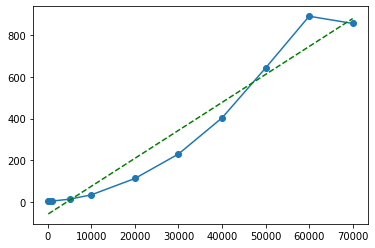

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = df_time['size']
y = df_time['time']
plt.plot(x, y)
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--")

plt.show()

Assuming a linear trend, how long would it take to process the entire StackSample dataset (around 1.2 million observations)?

In [21]:
import datetime
predict = np.poly1d(z)
size_needed = 1200000
prediction = predict(size_needed)
conversion = datetime.timedelta(seconds=prediction)
str(conversion)

'4:27:36.380771'